# 06-Extended Sources

While preparing the note for extended sources, I realized that the detailed explanations are either well explained by so many people, e.g., SExtractor user guides (included in the ``references`` directory of this repo) which provide extensive explanations on the API. Also see [``photutils.segmentation`` documentation](https://photutils.readthedocs.io/en/stable/segmentation.html) and [``photutils.isophot`` documentation](https://photutils.readthedocs.io/en/stable/isophote.html) for some educational tutorials. Moreover, there are some *hidden* tutorials such as [this online materials](https://photutils.readthedocs.io/en/stable/isophote.html#additional-example-notebooks-online). I urge you to follow those tutorials, but not only those, but also the referenced publications like Jedrzejewski (1987; MNRAS 226, 747). 

Since the remaining part is more like advanced science, I don't really think it is necessary to make any more explanatory notes. Here, I will show you *just another tutorial example* similar to that shown in ``photutils`` documentations above, but without much explanations. So **I recommend you to first look at the ``photutils`` documentations linked above, and then come back to this note to see this because it is nothing more than a simple and inferior, nearly copied-and-pasted summary**.

In [1]:
%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'last_expr'

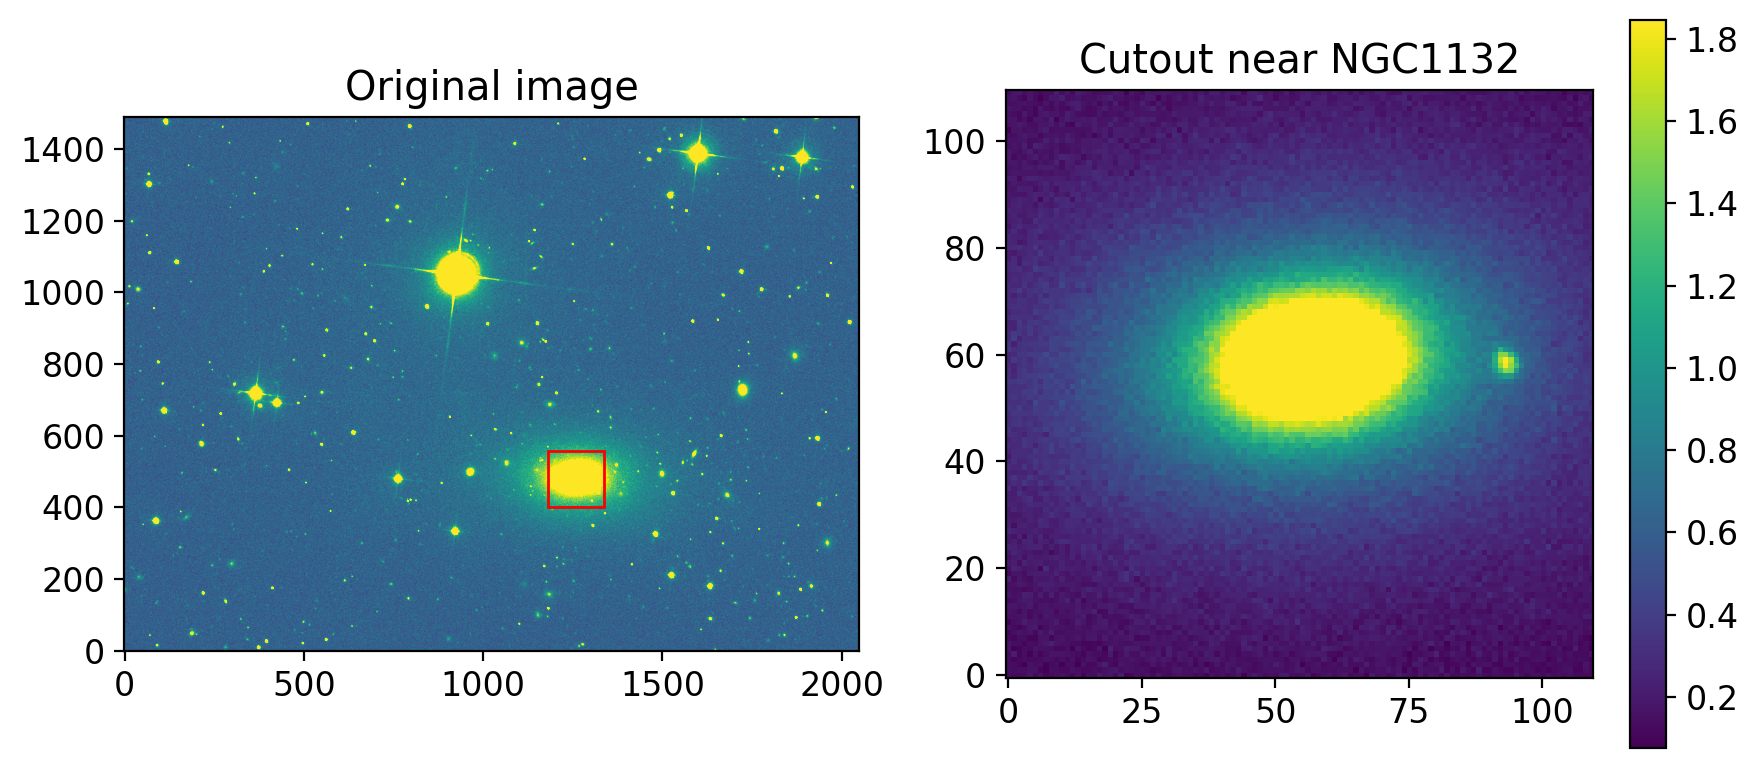

In [2]:
from pathlib import Path
import numpy as np

from astropy.table import Table
from astropy.nddata import CCDData
from astropy.stats import sigma_clipped_stats, gaussian_fwhm_to_sigma
from astropy.convolution import Gaussian2DKernel

from photutils.isophote import EllipseGeometry, Ellipse, build_ellipse_model
from photutils import EllipticalAperture, detect_sources, deblend_sources, Background2D, source_properties

from matplotlib import pyplot as plt
from matplotlib import rcParams

import ysfitsutilpy as yfu
import ysvisutilpy as yvu

plt.style.use('default')
rcParams.update({'font.size':12})

DATAPATH = Path("../../Tutorial_Data")
ccd_all = yfu.load_ccd(DATAPATH / "ngc1132_r.fits")
ccd = yfu.cutccd(ccd_all, position=(1260, 480), size=(110, 110))
data_all = ccd_all.data
data = ccd.data

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
yvu.norm_imshow(axs[0], data_all, zscale=True)
axs[0].plot(1260, 480, 's', ms=20, mfc='none', mec='r')
axs[0].set_title("Original image")
im = yvu.norm_imshow(axs[1], data, zscale=True)
plt.colorbar(im)

axs[1].set_title("Cutout near NGC1132")
plt.tight_layout()
plt.show()

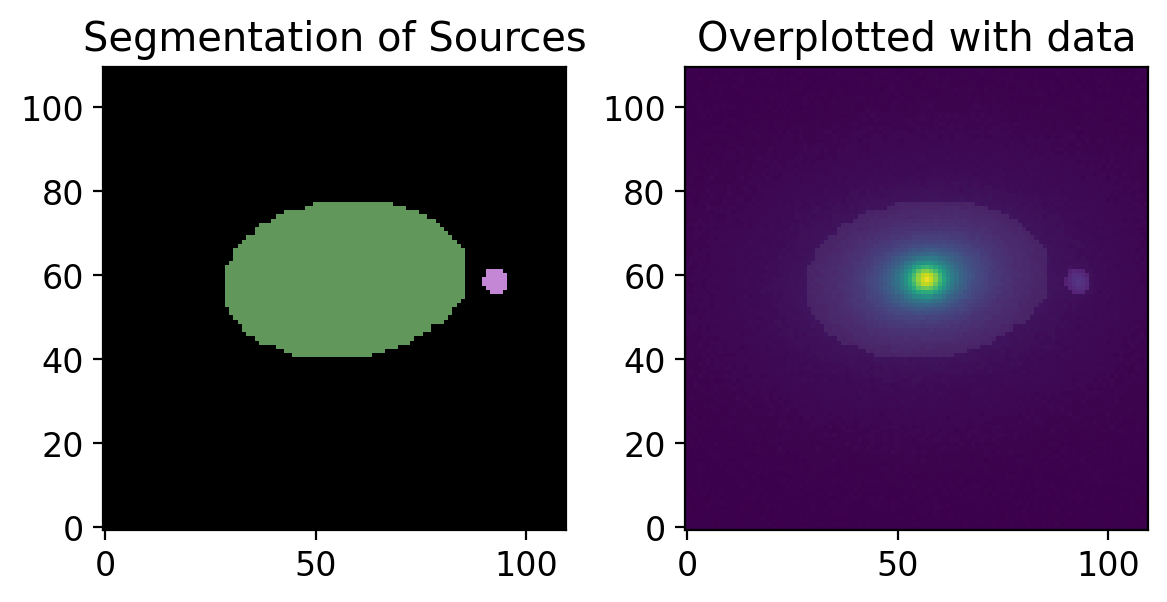

In [3]:
sigma = 3.0 * gaussian_fwhm_to_sigma    # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()

avg, med, std = sigma_clipped_stats(data, sigma=3, maxiters=5, std_ddof=1)
threshold = med + 3 * std
segm = detect_sources(data, threshold, npixels=5, filter_kernel=kernel)

fig, axs = plt.subplots(1, 2, figsize=(6, 4), sharex=False, sharey=False, gridspec_kw=None)
axs[0].imshow(segm, origin='lower', cmap=segm.make_cmap(random_state=12345))
axs[1].imshow(segm, origin='lower', cmap=segm.make_cmap(random_state=12345))
axs[1].imshow(data, origin='lower', alpha=0.9)

axs[0].set_title("Segmentation of Sources")
axs[1].set_title("Overplotted with data")
plt.tight_layout()

When you have multiple sources blended each other, you need deblending (see [documentation](https://photutils.readthedocs.io/en/stable/segmentation.html#source-deblending) for example and refer to the SExtractor guides included in the `references` directory of this repo).

In [4]:
cat = source_properties(data, segm)
cat.to_table()

id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,min_value,max_value,minval_xpos,minval_ypos,maxval_xpos,maxval_ypos,area,equivalent_radius,perimeter,semimajor_axis_sigma,semiminor_axis_sigma,orientation,eccentricity,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy,gini
,pix,pix,,,,,,,,pix,pix,pix,pix,,,pix,pix,pix,pix,pix2,pix,pix,pix,pix,deg,,,,pix2,pix2,pix2,1 / pix2,1 / pix2,1 / pix2,
int32,float64,float64,object,object,float64,object,object,object,object,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,56.91190509193456,59.056723059248625,None,None,3741.0380859375,None,None,None,None,29.0,85.0,41.0,77.0,0.8046875,14.171875,80.0,71.0,57.0,59.0,1709.0,23.323627408447816,157.63961030678928,11.465288379851941,7.473576961157405,5.787154660708165,0.7583532695097625,0.3481562160886601,1.5341098966988298,130.6842018236827,7.58398982963791,56.622988403827975,0.00771197829638107,-0.002065859348468733,0.017799020443011276,0.3711498776937082
2,92.79489107953478,58.55634048725456,None,None,36.3564453125,None,None,None,None,90.0,95.0,56.0,61.0,0.8310547,1.8417969,90.0,59.0,93.0,59.0,29.0,3.0382538898732494,17.071067811865472,1.4847544993331396,1.3475288633378044,-59.52340743181285,0.4198859345170639,0.09242311510554002,1.1018350253778089,1.915812626805112,-0.16988863626001724,2.104517334013365,0.5257351986174977,0.08488068450040984,0.4785943625118647,0.135971184990006


In [5]:
geometry = EllipseGeometry(x0=1263, y0=484, sma=20, eps=0.5, pa=0)
geometry.find_center(data)

INFO: Found center at x0 =  57.0, y0 =  60.0 [photutils.isophote.geometry]


In [6]:
ellipse = Ellipse(data, geometry)
isolist = ellipse.fit_image()      # photutils.isophote.isophote.IsophoteList

isolist.to_table()

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad,grad_err,grad_rerr,x0,x0_err,y0,y0_err,ndata,flag,niter,stop_code
,,,,,deg,deg,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,float64,float64,int64,int64,int64,int64
0.0,14.102967963488974,0.0,0.0,0.0,0.0,0.0,0.0,None,None,56.98108231630539,0.0,59.07099644233199,0.0,1,0,0,0
0.5346972612827552,13.644819835599792,0.0112142268973086,0.06955769841643354,0.022783949711357145,1.647712252382929,10.39206968073577,-0.9234585065504064,0.3062322767046471,0.3316145495790412,56.98108231630539,0.006554974900491666,59.07099644233199,0.006483902086916693,13,0,10,0
0.5881669874110307,13.596853163466973,0.01179018584843644,0.07245676183099113,0.022064708735843604,2.0423649329804268,9.671678682935665,-0.9082890771420665,0.2919494081777611,0.3214278532297014,56.977596363558725,0.007108442776573368,59.07728162527961,0.006912592407151193,13,0,10,0
0.6469836861521338,13.545110163132042,0.012336997852615253,0.07566272038723307,0.02126816928384195,2.5036008642037366,8.943506311237515,-0.8916612655319437,0.2768887351526474,0.3105313035970697,56.973392337699515,0.007646886010948783,59.08401973567574,0.0073492023678532956,13,0,10,0
0.7116820547673471,13.489438960503294,0.012845544712447785,0.07921164208094333,0.02050720267695218,3.0467125221786455,8.23455477838403,-0.8734531459711664,0.26117143056919156,0.2990102351498235,56.96831356753729,0.008203786956093419,59.091217077685904,0.007779412011636731,13,0,10,0
0.7828502602440819,13.429725331524578,0.013310239736259983,0.08314558040316956,0.019723002046019504,3.691704555140892,7.615851278010311,-0.8535439493645994,0.24500476732908438,0.28704411473067365,56.96217201012994,0.008054439789221575,59.09887102684534,0.008223481428132418,13,0,10,0
0.8611352862684901,13.365936784117654,0.013732183210788023,0.0875876682627303,0.018862749652525473,4.464056577794609,6.919963054560517,-0.8317991441362091,0.22871063030479297,0.2749589632510382,56.95475621038863,0.008865574953467738,59.10694237623504,0.008655237623108943,13,0,10,0
0.9472488148953392,13.298621664145308,0.014281378561960871,0.09321275069186308,0.01651562941798521,5.821381295874854,5.684460875781153,-0.892393165837773,0.1996501851568821,0.223724466748299,56.945904101183615,0.00862525390190618,59.114902432733416,0.008334641282819267,13,0,10,0


For the explanation of all the available columns, please refer to the [``photutils.IsophotList`` documentation](https://photutils.readthedocs.io/en/stable/api/photutils.isophote.IsophoteList.html#photutils.isophote.IsophoteList)

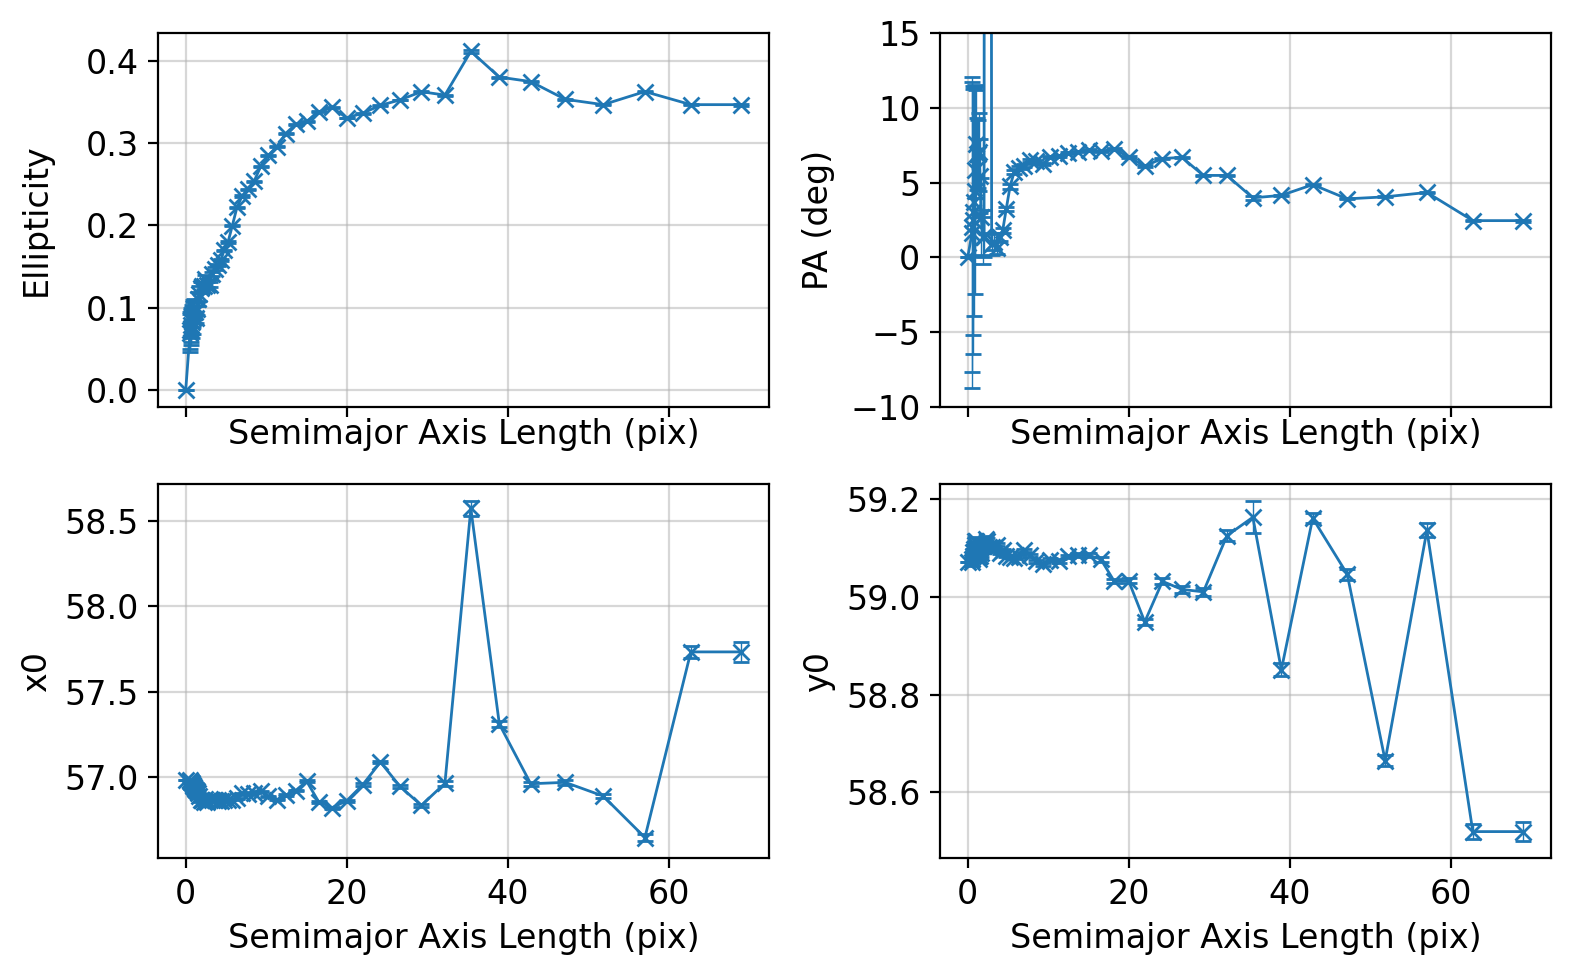

In [7]:
errbfmt = dict(marker='x', ls='-', lw=1, capsize=3, elinewidth=0.5)

fig, axs = plt.subplots(2, 2, figsize=(8, 5), 
                        sharex=True, sharey=False, gridspec_kw=None)

ax_ae = axs[0, 0]
ax_ap = axs[0, 1]
ax_ax = axs[1, 0]
ax_ay = axs[1, 1]

ax_ae.errorbar(isolist.sma, isolist.eps, yerr=isolist.ellip_err, **errbfmt)
ax_ae.set(
    xlabel='Semimajor Axis Length (pix)',
    ylabel='Ellipticity'
)

ax_ap.errorbar(isolist.sma, isolist.pa/np.pi*180., yerr=isolist.pa_err/np.pi*180., **errbfmt)
ax_ap.set(
    xlabel='Semimajor Axis Length (pix)',
    ylabel='PA (deg)',
    ylim=(-10, 15)
)

ax_ax.errorbar(isolist.sma, isolist.x0, yerr=isolist.x0_err, **errbfmt)
ax_ax.set(
    xlabel='Semimajor Axis Length (pix)',
    ylabel='x0'
)

ax_ay.errorbar(isolist.sma, isolist.y0, yerr=isolist.y0_err, **errbfmt)
ax_ay.set(
    xlabel='Semimajor Axis Length (pix)',
    ylabel='y0'
)

yvu.linticker(axs.flatten())

plt.tight_layout()
fig.align_ylabels(axs)
fig.align_xlabels(axs)
plt.show()

As of photutils 0.7, there is a bug in ``build_ellipse_model`` (Pull Request [here](https://github.com/astropy/photutils/pull/1039)). Please use newer version.

Text(0.5, 1.0, 'Residual')

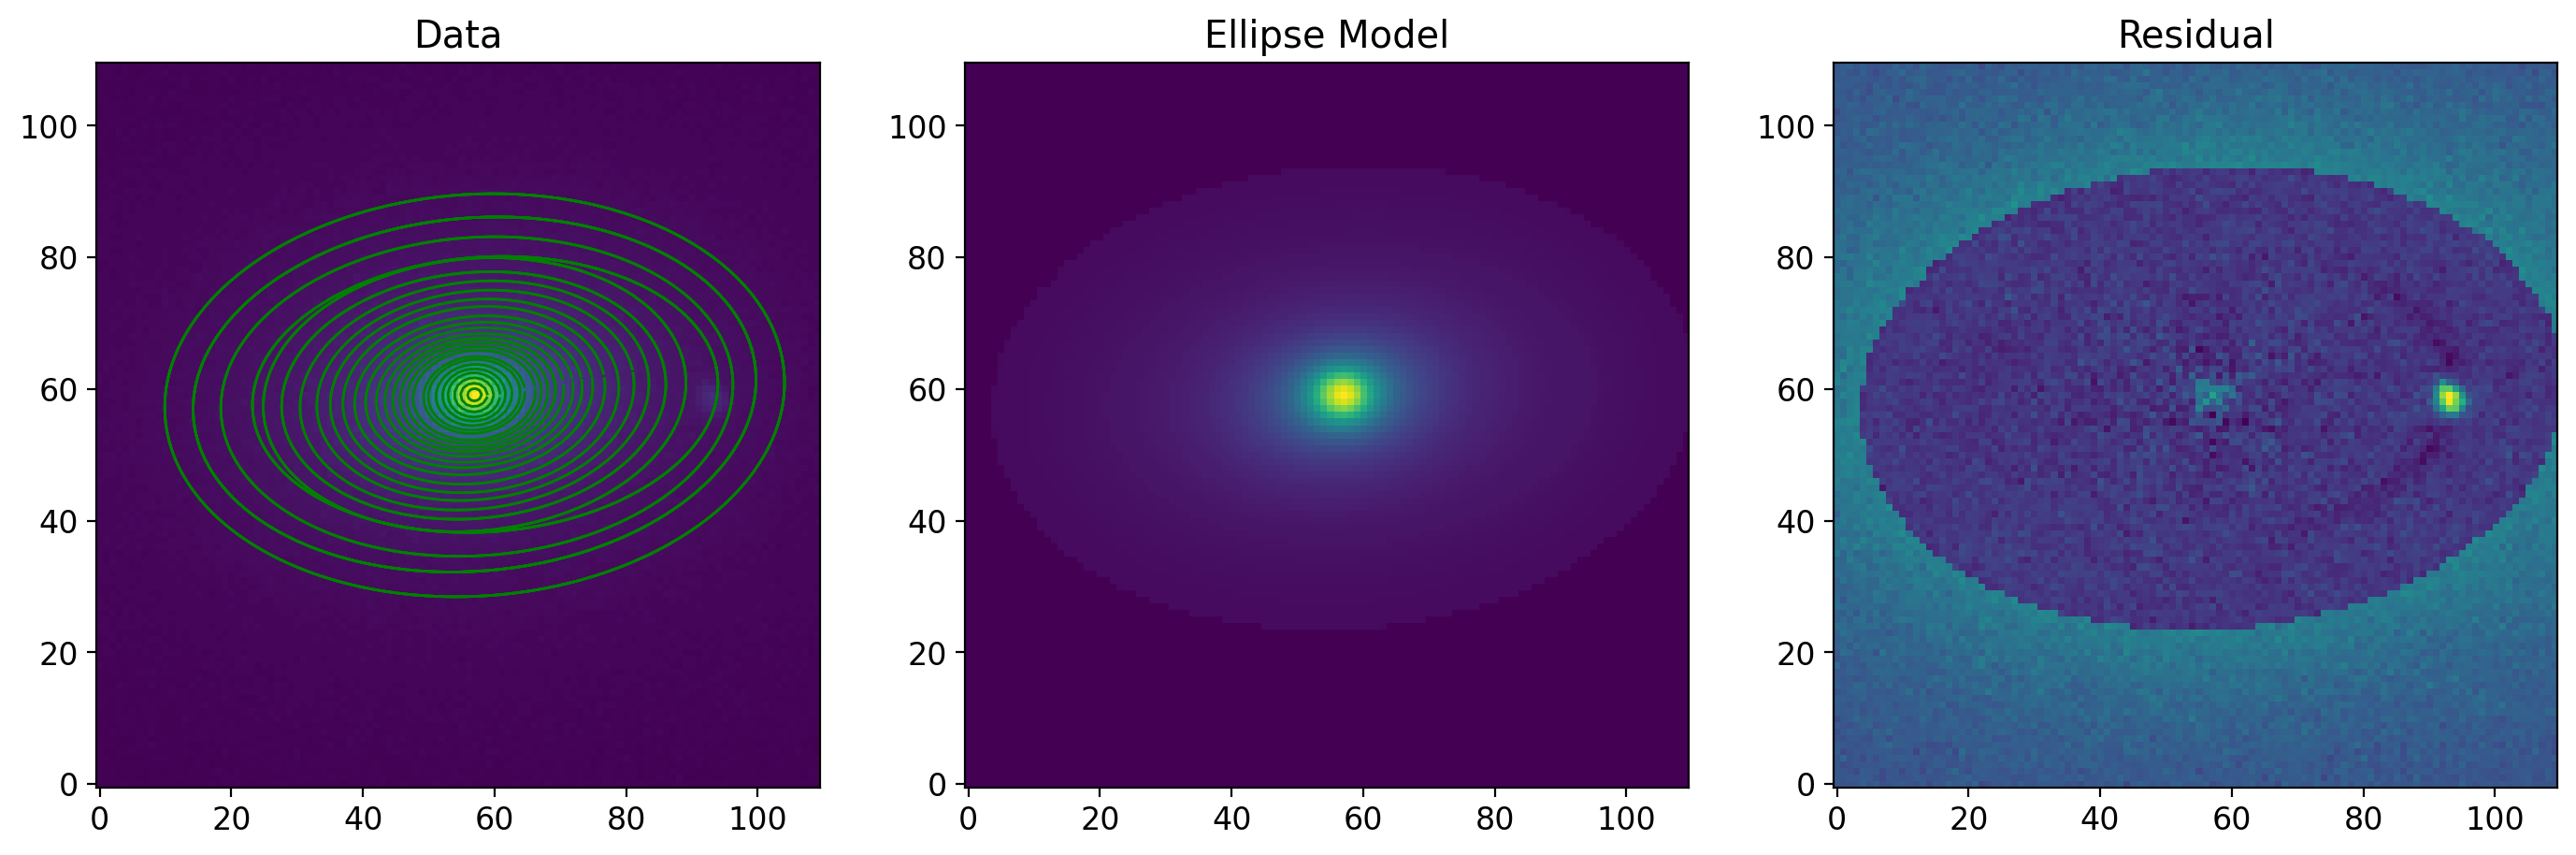

In [8]:
model_image = build_ellipse_model(data.shape, isolist)
residual = data - model_image

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 5), nrows=1, ncols=3)
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.02, top=0.98)
ax1.imshow(data, origin='lower')
ax1.set_title('Data')

smas = np.arange(50)
for sma in smas:
    iso = isolist.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    ax1.plot(x, y, color='g', lw=1)

ax2.imshow(model_image, origin='lower')
ax2.set_title('Ellipse Model')

ax3.imshow(residual, origin='lower')
ax3.set_title('Residual')